# Machine Learning for Flow Cytometry

One of the directions `CytoFlow` is going in that I'm most excited about is the application of advanced machine learning methods to flow cytometry analysis.  After all, cytometry data is just a high-dimensional data set with many data points: making sense of it can take advantage of some of the sophisticated methods that have seen great success with other high-throughput biological data (such as microarrays.)

The following notebook demonstrates a basic unsupervised machine learning method, Gaussian Mixture Models, applied to the demo data set we worked with in "Basic Cytometry."

Set up the Jupyter notebook and import `cytoflow`.

In [1]:
%matplotlib inline

import cytoflow as flow

We have two `Tube`s of data that we specify were treated with two different concentrations of the inducer Doxycycline.

In [2]:
tube1 = flow.Tube(file = 'data/RFP_Well_A3.fcs',
                  conditions = {"Dox" : 10.0})
tube2 = flow.Tube(file='data/CFP_Well_A4.fcs',
                  conditions = {"Dox" : 1.0})

import_op = flow.ImportOp(conditions = {"Dox" : "float"},
                          tubes = [tube1, tube2])

ex = import_op.apply()

Let's look at the histogram of the `Y2-A` channel (on a `logicle` plot scale).

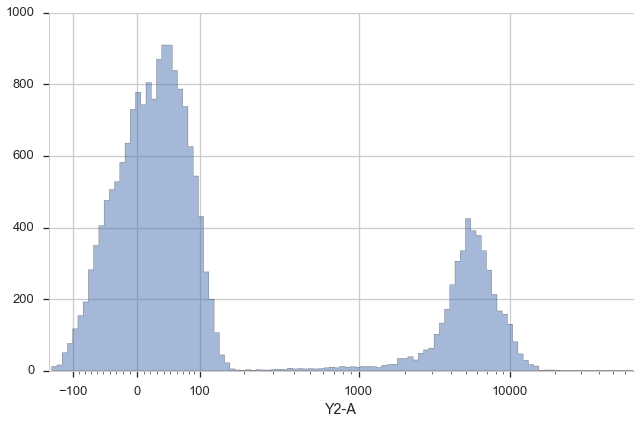

In [3]:
flow.HistogramView(name = "Histogram view",
                   scale = 'logicle',
                   channel = 'Y2-A').plot(ex)

This data looks bimodal to me!  Not perfect Gaussians, but close enough that using a Gaussian Mixture Model will probably let us separate them.

`CytoFlow` includes two different modules that implement Gaussian Mixture Models, a 1D model (for one channel) and a 2D model (for two channels!).  The 1D GMM, named `GaussianMixtureModel1DOp`, is parameterized with a channel name and the number of model components to fit.

`cytoflow` separates the estimation of module parameters from their application; after instantiating the `Operation`, you call `estimate()` to estimate the model parameters.  Those parameters stay associated with the `Operation`, in the same way instances of `ThresholdOp` have the gate threshold as an instance attribute.

Finally, many modules, including `GaussianMixtureModel1DOp`, have a `default_view()` method that returns a diagnostic plot so you can check to see that the parameter estimation worked.  This is particularly important for unsupervised learning methods!  In this case, the `GaussianMixtureModel1DOp`'s `default_view()` returns a `View` that plots a histogram, colored by the component each event was assigned to, and an overlay of the Gaussian distributions on top of the histogram.

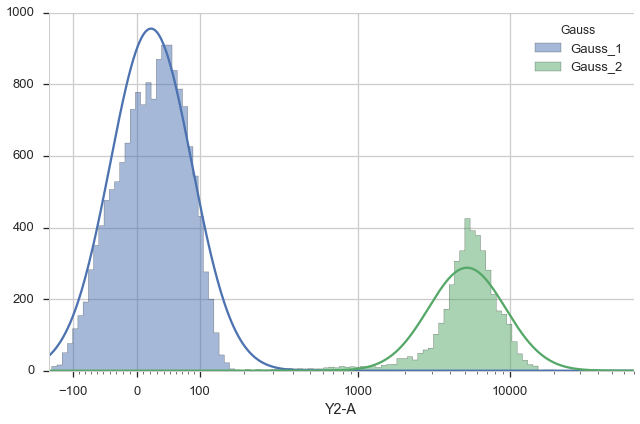

In [4]:
g = flow.GaussianMixture1DOp(name = "Gauss",
                             channel = "Y2-A",
                             scale = "logicle",
                             num_components = 2)

g.estimate(ex)
g.default_view().plot(ex)

Excellent.  It looks like the GMM found the two distributions we were looking for.  When you `apply()` the `GaussianMixtureModel1DOp`, it adds a new piece of metadata to each event in the data set:
* The metadata name is the same as the name of the operation (in this case, `Gauss`)
* The values are {Name}\_{#}, where {Name} is the name of the operation and {#} is the index of the event.  So,
  in this example the events would be labeled "Gauss_1" or "Gauss_2".  
  
We can re-create the above plot (without the Gaussian distribution functions) using `HistogramView.plot()` with a hue facet.

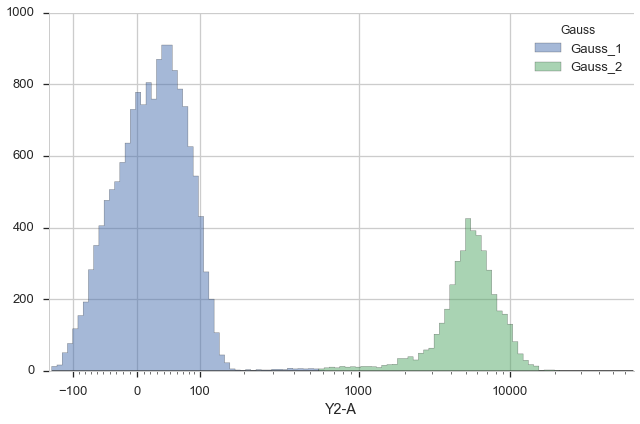

In [5]:
ex2 = g.apply(ex)
flow.HistogramView(channel = "Y2-A",
                   scale = "logicle",
                   huefacet = "Gauss").plot(ex2)

There's an important subtlety to notice here.  In the plot above, we set the data scale on the `HistogramView`, but prior to that we passed `scale = "logicle"` to the `GaussianMixtureModel1DOp` *operation*.  We did so in order to fit the gaussian model to the *scaled data*, as opposed to the raw data.  Because `default_view()` is linked to the `GaussianMixtureModel1DOp` instance, we didn't have to re-specify the scale.

This is an example of a broader design goal: in order to enable more quantitative analysis, `cytoflow` does not re-scale the underlying data; rather, it transforms it before displaying it.  Frequently it is useful to perform the same transformation before doing data-driven things, so many modules that have an `estimate()` function also allow you to specify a `scale`.

Since we're going to be using the `logicle` scale for the rest of the example, let's set it as the default so we don't have to keep asking for it explicity.

In [6]:
flow.set_default_scale("logicle")

A 1-dimensional gaussian mixture model works well if the populations are well-separated.  However, if they're closer together, you may only want to keep events that are "clearly" in one distribution or another.  One way to accomplish this by passing a `sigma` parameter to `GaussianMixtureModel1D`.  This doesn't change the behavior of `estimate()`, but when you `apply()` the operation it only assigns events that are within `sigma` multiples of the standard deviation to `{Name}_{#}`; events that fall outside of those gates are assigned to `{Name}_None`.

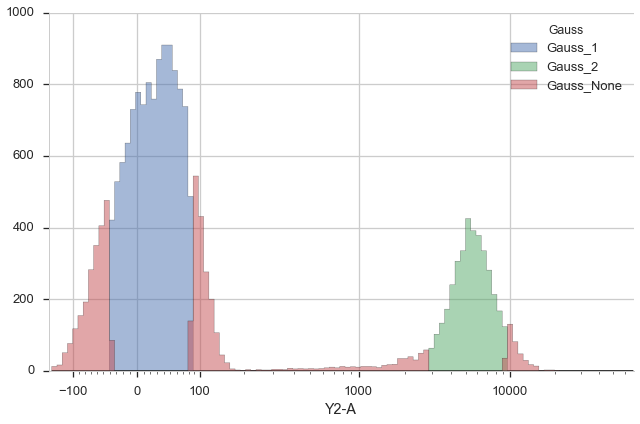

In [7]:
g = flow.GaussianMixture1DOp(name = "Gauss",
                             channel = "Y2-A",
                             num_components = 2,
                             sigma = 1)

g.estimate(ex)
ex2 = g.apply(ex)
flow.HistogramView(channel = "Y2-A",
                   huefacet = "Gauss").plot(ex2)

Sometimes, mixtures are very close and separating them is difficult.  In such cases it may be better to filter the events based on the _posterior probability_ that they are actually members of the components to which they were assigned.  We can get this behavior by passing `posterior = True` as a parameter to `GaussianMixture1DOp`.

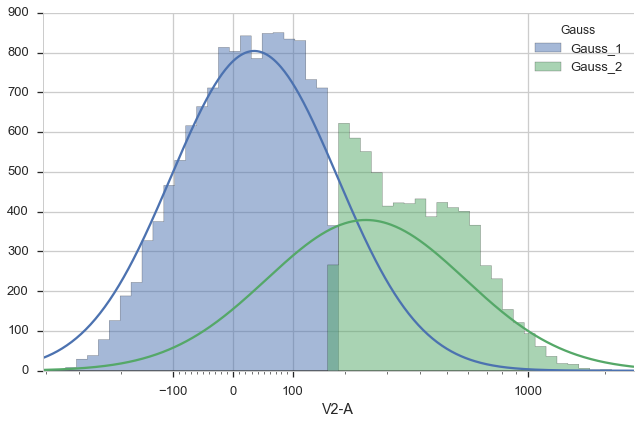

In [8]:
g = flow.GaussianMixture1DOp(name = "Gauss",
                             channel = "V2-A",
                             num_components = 2,
                             posteriors = True)

g.estimate(ex)
g.default_view().plot(ex)

If `posteriors = True`, the `GaussianMixture1DOp.apply()` adds a second metadata column, `{Name}_Posterior`, that contains each event's posterior probability.

In [9]:
ex2 = g.apply(ex)

print ex2.data.head()

         B1-A        B1-H          B1-W  Dox       FSC-A       FSC-H  \
0 -127.094002  257.718353 -63040.300781   10  459.962982  437.354553   
1  -70.234840  255.798340 -34034.042969   10 -267.174652  365.354553   
2  -96.471756  313.398346 -41931.687500   10 -201.582336  501.354553   
3   18.831570  277.669250   8514.489258   10  291.259888  447.029755   
4  100.882095  255.756256  51291.074219   10 -397.168579  354.565308   

           FSC-W      HDR-T        SSC-A        SSC-H          SSC-W  \
0  137847.578125   2.018511   840.091370   747.917847  147225.328125   
1  -95849.679688  27.451754  3476.902344  3163.917969  144038.046875   
2  -52700.828125  32.043865   480.270691   507.917877  123937.437500   
3   85399.273438  79.327492  8026.275879  6741.838867  156043.484375   
4 -146821.125000  79.731194  7453.750488   609.884277  262143.968750   

         V2-A        V2-H           V2-W         Y2-A         Y2-H  \
0   41.593452  240.153854   22701.017578   109.946274   153.6300

We can use this second metadata column to filter out events with low posterior probabilities:

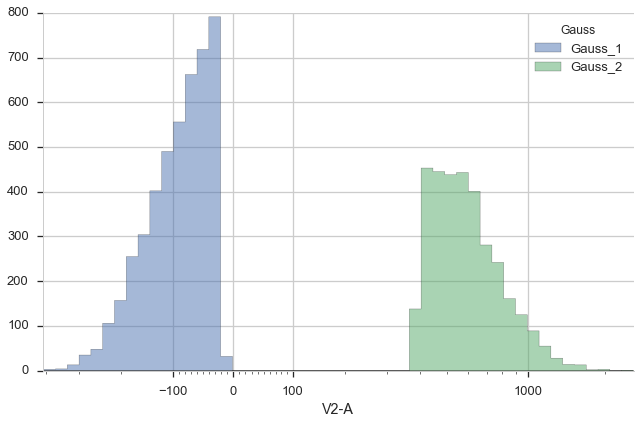

In [10]:
flow.HistogramView(channel = "V2-A",
                   huefacet = "Gauss",
                   subset = "Gauss_Posterior > 0.8").plot(ex2)

Finally, sometimes you don't want to use the same model parameters for your entire data set.  Instead, you want to estimate different parameters for different subsets.  `cytoflow`'s data-driven modules allow you to do so with a `by` parameter, which _aggregates_ subsets before estimating model parameters.  You pass `by` an array of metadata columns, and the module estimates a new model for each unique subset of those metadata.

For example, let's look at the `V2-A` channel faceted by `Dox`:

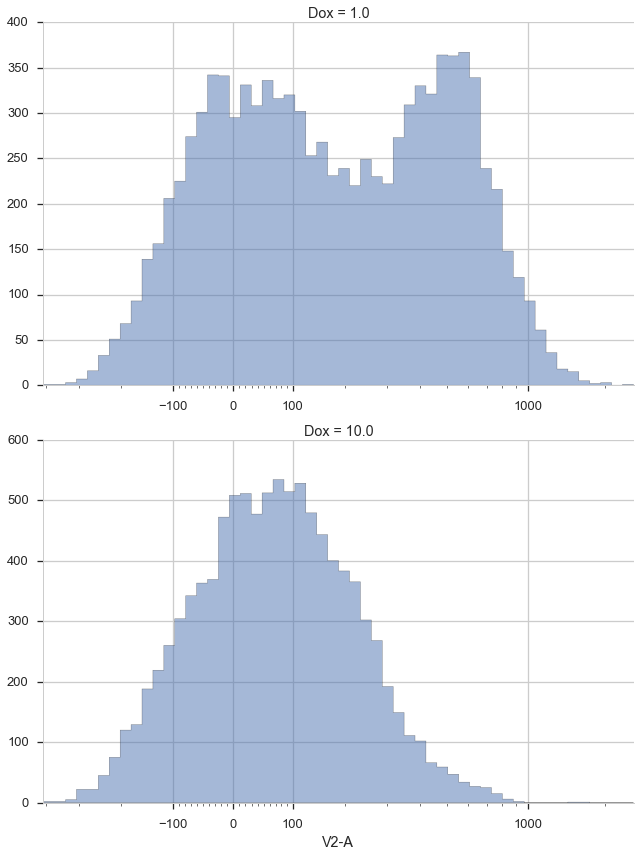

In [11]:
flow.HistogramView(channel = "V2-A", 
                   yfacet = "Dox").plot(ex)

It's pretty clear that the `Dox == 1.0` condition and the `Dox == 10.0` condition are different; a single 2-component GMM won't fit both of them.  So let's fit a model to each unique value of `Dox`.  Note that `by` takes a *list* of metadata columns; you must pass it a list, even if there's only one element in the list.

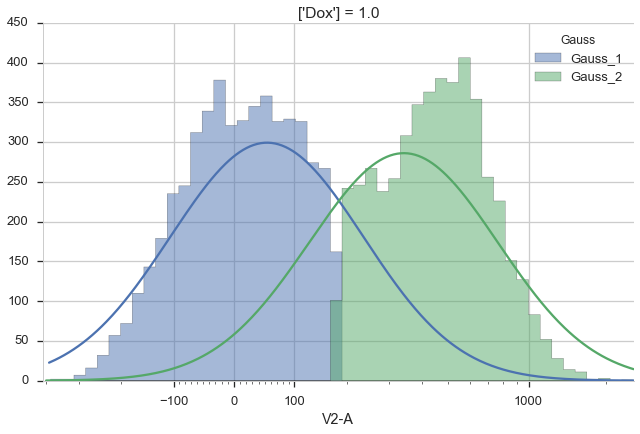

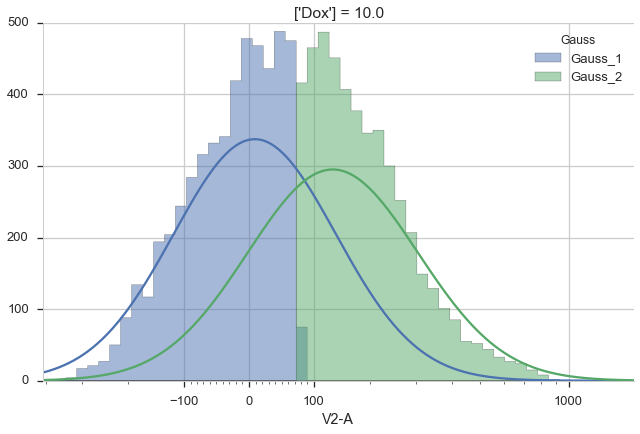

In [12]:
g = flow.GaussianMixture1DOp(name = "Gauss",
                             channel = "V2-A",
                             num_components = 2,
                             by = ["Dox"])

g.estimate(ex)
g.default_view().plot(ex)

This time the `View` returned by `default_view()` gives us multiple plots, one for each subset of the data (and thus one per model that was estimate.)  You can see that the models are substantially different.

It is important to note that while the estimated model parameters differ between subsets, it is not currently possible to specify different _module parameters_ across subsets.  For example, you can't specify that the `Dox = 1.0` subset have two GMM components, but `Dox == 10.0` have only one.  If we could _estimate_ the number of components, on the other hand, using (say) an AIC or BIC information criterion, then different subsets could have different numbers of components. 

#2D Gaussian Mixture Models

`cytoflow` also includes an operation for a 2D Gaussian Mixture Model.  It operates exactly the same way as the 1D version we explored above.

Basic usage, assigning each event to one of the mixture components:  (the isolines in the `default_view()` are 1, 2 and 3 standard deviations away from the mean.)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


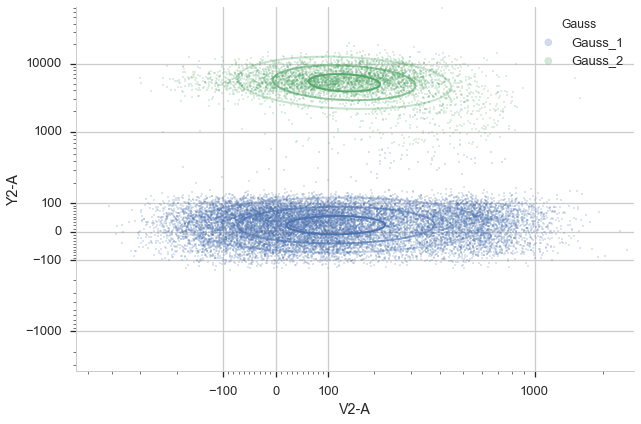

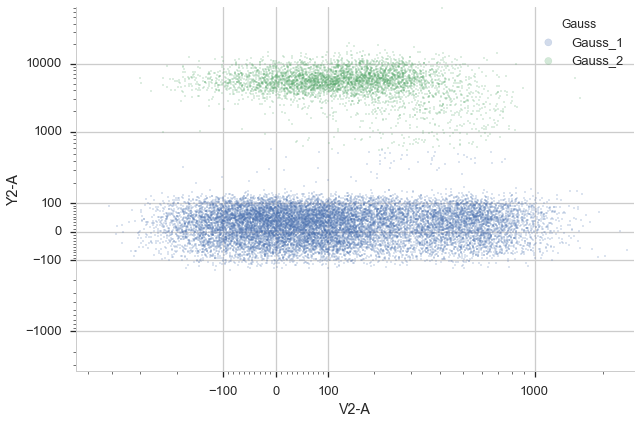

In [13]:
g = flow.GaussianMixture2DOp(name = "Gauss",
                             xchannel = "V2-A",
                             ychannel = "Y2-A",
                             num_components = 2)
g.estimate(ex)
g.default_view().plot(ex)

ex2 = g.apply(ex)
flow.ScatterplotView(xchannel = "V2-A",
                     ychannel = "Y2-A",
                     huefacet = "Gauss").plot(ex2)

Subsetting based on standard deviation:

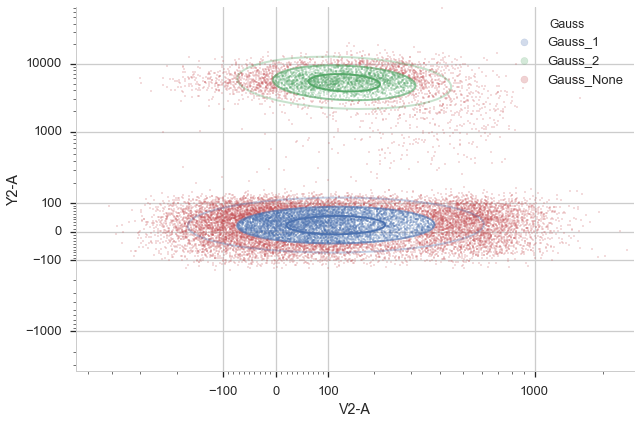

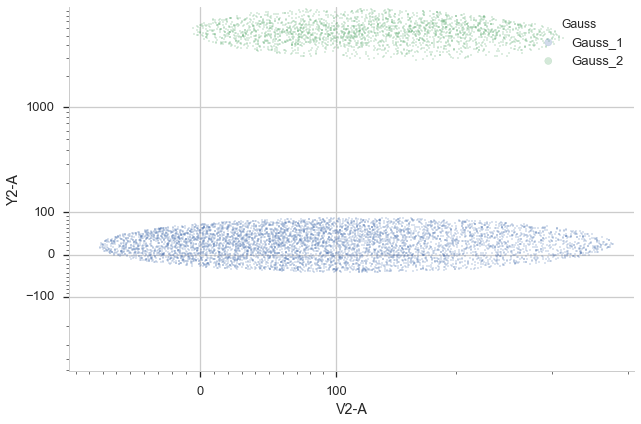

In [14]:
g = flow.GaussianMixture2DOp(name = "Gauss",
                             xchannel = "V2-A",
                             ychannel = "Y2-A",
                             num_components = 2,
                             sigma = 2)
g.estimate(ex)
g.default_view().plot(ex)

ex2 = g.apply(ex)
flow.ScatterplotView(xchannel = "V2-A",
                     ychannel = "Y2-A",
                     huefacet = "Gauss",
                     subset = "Gauss != 'Gauss_None'").plot(ex2)

Gating based on posterior probabilities:

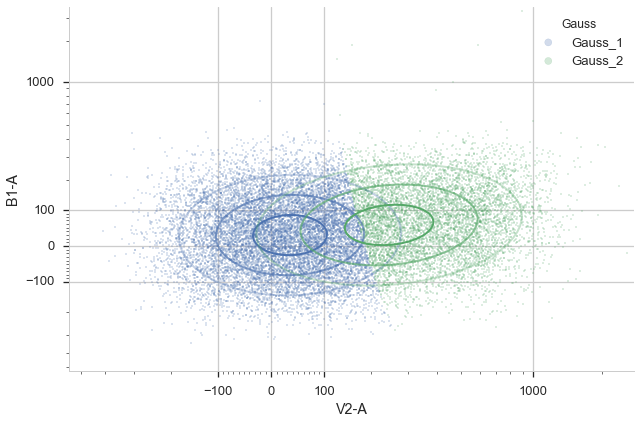

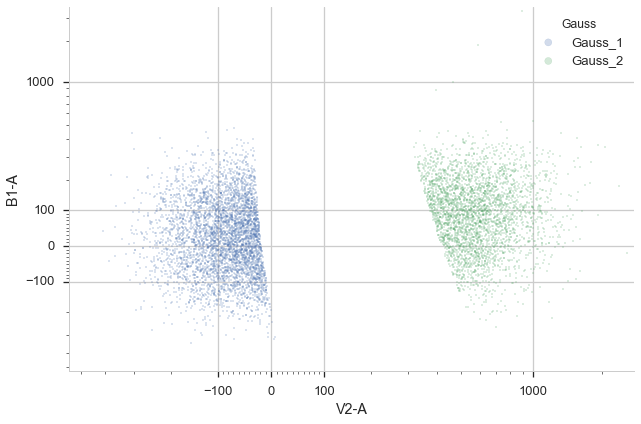

In [15]:
g = flow.GaussianMixture2DOp(name = "Gauss",
                             xchannel = "V2-A",
                             ychannel = "B1-A",
                             num_components = 2,
                             posteriors = True)
g.estimate(ex)
g.default_view().plot(ex)

ex2 = g.apply(ex)
flow.ScatterplotView(xchannel = "V2-A",
                     ychannel = "B1-A",
                     huefacet = "Gauss",
                     subset = "Gauss_Posterior > 0.8").plot(ex2)

And multiple models for different subsets:

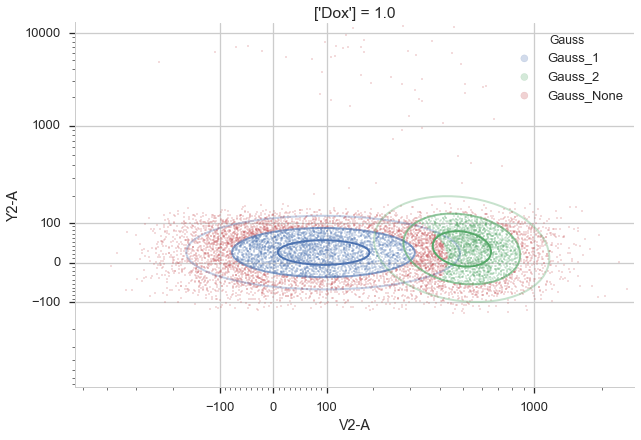

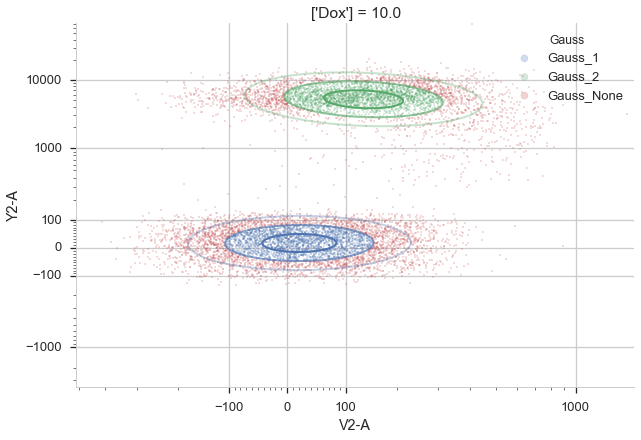

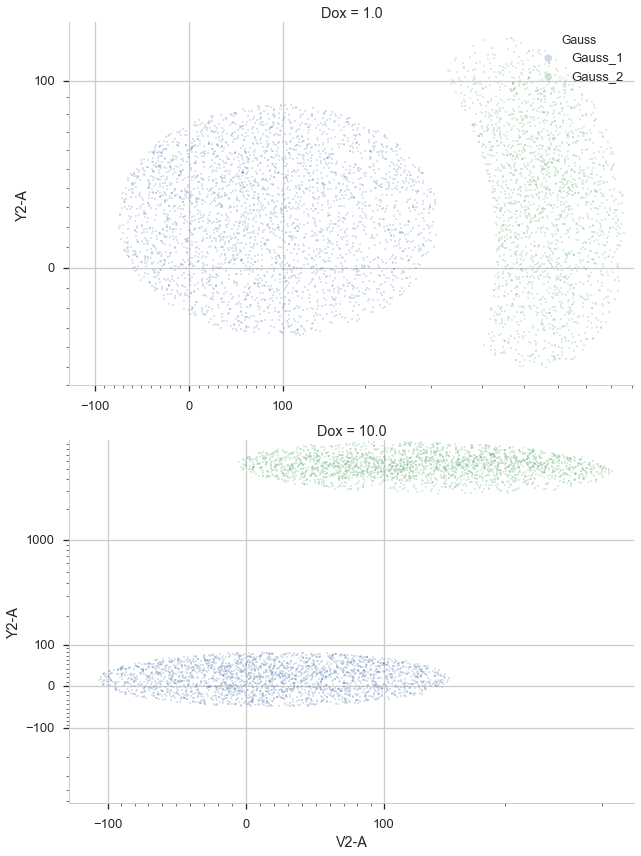

In [16]:
g = flow.GaussianMixture2DOp(name = "Gauss",
                             xchannel = "V2-A",
                             ychannel = "Y2-A",
                             num_components = 2,
                             sigma = 2,
                             by = ["Dox"])
g.estimate(ex)
g.default_view().plot(ex)

ex2 = g.apply(ex)
flow.ScatterplotView(xchannel = "V2-A",
                     ychannel = "Y2-A",
                     huefacet = "Gauss",
                     yfacet = "Dox",
                     subset = "Gauss != 'Gauss_None'").plot(ex2)

This is just the beginning of what I'd like to see `cytoflow` accomplish.  Supervised learning with k-mean?  Principle component analysis?  Anything is fair game, and with the diversity of the scientific Python ecosystem the hard part (writing the algorithms!) has mostly been done already.